# Spatio-Temporal Traffic Forecasting with Neural Graph Cellular Automata
Petrônio C.  L. Silva  <span itemscope itemtype="https://schema.org/Person"><a itemprop="sameAs" content="https://orcid.org/0000-0002-1202-2552" href="https://orcid.org/0000-0002-1202-2552" target="orcid.widget" rel="noopener noreferrer" style="vertical-align:top;"><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-right:.5em;" alt="ORCID iD icon"></a></span>, Omid Orang  <span itemscope itemtype="https://schema.org/Person"><a itemprop="sameAs" content="https://orcid.org/0000-0002-4077-3775" href="https://orcid.org/0000-0002-4077-3775" target="orcid.widget" rel="noopener noreferrer" style="vertical-align:top;"><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-right:.5em;" alt="ORCID iD icon"></a></span>, Lucas Astore, Frederico G. Guimarães <span itemscope itemtype="https://schema.org/Person"><a itemprop="sameAs" content="https://orcid.org/0000-0001-9238-8839" href="https://orcid.org/0000-0001-9238-8839" target="orcid.widget" rel="noopener noreferrer" style="vertical-align:top;"><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-right:.5em;" alt="ORCID iD icon"></a></span>

In case you have any questions, do not hesitate in contact us using the following e-mail: petronio.candido@ifnmg.edu.br


## Imports

In [1]:
from datetime import datetime, timezone, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from sklearn.manifold import SpectralEmbedding

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from tensordict import TensorDict

from st_nca.common import DEVICE, resume, checkpoint
from st_nca.datasets import PEMS03, SensorDataset
from st_nca.cellmodel import CellModel
from st_nca.pretrain import training_loop
from st_nca.gca import GraphCellularAutomata

from st_nca.embeddings.temporal import from_datetime_to_np

## Data

In [2]:
DEFAULT_PATH = 'C:\\Users\\petro\\Dropbox\\Projetos\\futurelab\\posdoc\\st_nca\\'

edges_file = DEFAULT_PATH + 'PEMS03.csv'
nodes_file = DEFAULT_PATH + 'pems03_preprocessed.csv'
data_file = DEFAULT_PATH + 'PEMS03_data_THIS_ONE.csv'

pems = PEMS03(edges_file=edges_file, nodes_file=nodes_file, data_file=data_file)

c:\Users\petro\Dropbox\Projetos\futurelab\posdoc\st_nca\st_nca\st_nca\embeddings\normalization.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=self.dtype, device=self.device)


(358, 2)


## Cell Model Training

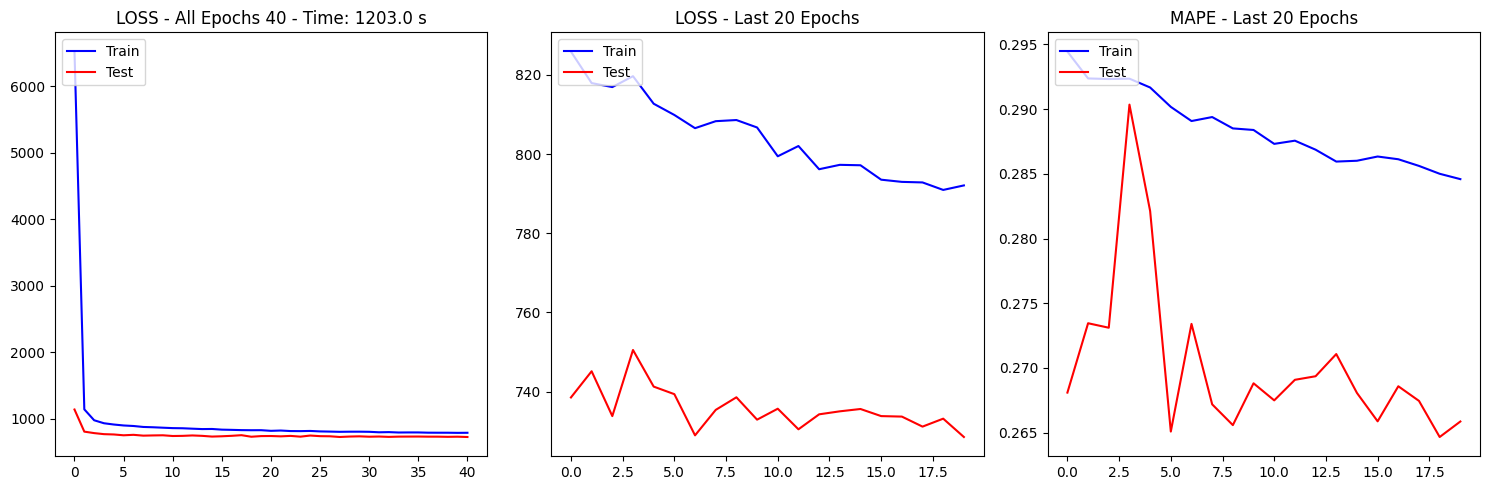

In [ ]:
DTYPE = torch.float32
NTRANSF = 2
NHEADS = 4
NTRANSFF = 256
TRANSFACT = nn.GELU()
MLP = 2
MLPD = 256
MLPACT = nn.GELU()

#ds = pems.get_fewsensors_dataset([311930, 312564, 312807, 312900, 313172, 314697, 315938, 317141, 318135, 318443 ], dtype=torch.float32, behavior='selfsupervised')
#ds = pems.get_sensor_dataset(311930, dtype=torch.float32, behavior='nondeterministic')
ds, sensors = pems.get_breadth_dataset(314697, max_sensors=20, 
                                       dtype=DTYPE,
                                       behavior='selfsupervised')

ds = ds.to(DEVICE)

cm = CellModel(num_tokens = ds.max_length, dim_token = ds.token_dim,
               num_transformers = NTRANSF, num_heads = NHEADS, feed_forward = NTRANSFF, 
               transformer_activation = TRANSFACT,
               mlp = MLP, mlp_dim = MLPD, mlp_activation = MLPACT,
               device = DEVICE, dtype = DTYPE)

training_loop(DEVICE, ds, cm,  batch=2048, epochs=100, lr=0.001,
              checkpoint_file='cell_model_{}_{}_{}_{}_{}'.format(NTRANSF,NHEADS,NTRANSFF,MLP,MLPD))

## Graph CA

In [ ]:
ds, sensors = pems.get_breadth_dataset(314697, max_sensors=20, 
                                       dtype=torch.float64,
                                       behavior='deterministic')

cm = CellModel(num_tokens = ds.max_length, dim_token = ds.token_dim,
               num_transformers = NTRANSF, num_heads = NHEADS, feed_forward = NTRANSFF, 
               transformer_activation = TRANSFACT,
               mlp = MLP, mlp_dim = MLPD, mlp_activation = MLPACT,
               device = DEVICE, dtype = DTYPE)

resume(cm, DEFAULT_PATH + 'cell_model_{}_{}_{}_{}_{}'.format(NTRANSF,NHEADS,NTRANSFF,MLP,MLPD))

subgraph = pems.G.subgraph(sensors)

gca = GraphCellularAutomata(device=cm.device, dtype=cm.dtype, graph = subgraph,
                            max_length = pems.max_length, token_size=pems.token_dim,
                            tokenizer=pems.tokenizer, cell_model = cm)

dt = datetime(year=2018, month=9, day=1, hour=23, minute=0)

df = pems.data[(pems.data['timestamp'] == from_datetime_to_np(dt))]

initial_state = {}
for sensor in subgraph.nodes():
    initial_state[str(sensor)] = df[str(sensor)].values[0]

print(initial_state)

gca.run(dt, initial_state, 10, 'minute', 5)



{'313190': 24.0, '314697': 68.0, '314730': 60.0, '314698': 26.0, '313166': 22.0, '315827': 6.0, '313172': 27.0, '315828': 0.0, '315830': 25.0, '315831': 25.0}


[TensorDict(
     fields={
         313166: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
         313172: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
         313190: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
         314697: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
         314698: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
         314730: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
         315827: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
         315828: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
         315830: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
         315831: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=F